In [6]:
# 所有的需要import的package
# 需要提前安装chrome driver，安装方式参考 https://blog.csdn.net/wendyw1999/article/details/107414953
# 所有需要提前下载的依赖package都在requirements里面
# 批量安装：在cmd/terminal当前目录下输入: pip install -i requirements.txt
from __future__ import unicode_literals

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import re
import requests
import os, os.path
from whoosh import index
from whoosh.qparser import QueryParser

import os, os.path
from whoosh import index
from jieba.analyse import ChineseAnalyzer

import pdfplumber
import whoosh.index as index

# ix = index.open_dir("indexdir")
from whoosh.query import And,Term,Or


from whoosh.fields import Schema, STORED, ID, KEYWORD, TEXT
import urllib

In [21]:
# webdriver 
def initialize():
    '''
    初始化一个Selenium chrome driver
    '''
    options = Options()
    options.add_argument("--headless")  # 无界面
    driver = webdriver.Chrome(options=options)   
    return driver

# 找到pdf所在的页面（html）
def find_report_links(id_list):   
    
    root_url = "http://data.eastmoney.com/notices/stock/"
    driver = initialize()
    print("Initializing Chrome Driver...")
    report_list = {}
    for i in id_list:
        print("Working on:  "+str(i))
        raw_url = root_url+str(i)+".html"
        
        try:
            driver.get(raw_url)
            report_link = click_next_page(driver)
            report_list[i]=report_link
            
        except:
            print('did not find the page on site')
    print("Closing Chrome Driver") 
    driver.quit()
    return report_list
#虚拟点击下一页
def click_next_page(driver):
    '''
    翻页
    '''
    time.sleep(2)
    curr_page = 1
    #check find report
    
    while True:
        
        try:
            
            
            found = find_report(driver)
            if found != False:
                print("Found the element at page: "+str(curr_page))
                
                return found
            next_page = driver.find_element_by_link_text("下一页")
            
            if next_page.get_attribute("class") == "nolink":
                print("Reached The Last Page,没有找到社会责任报告")
                
                return False
            next_page.click()
            curr_page+=1
            
            
            
        except:
            print("Something went wrong")
            print(curr_page)
            
            return False
            
        
            
# 在公告页面 翻页找到社会报告关键词的帖子    
def find_report(driver):
    '''
    网络爬虫找到社会责任报告帖子url，本页没有就翻页
    '''
    titles = driver.find_elements_by_class_name("overflow")
    pattern = re.compile(r'社会责任')
    for title in titles:
        check_match = bool(pattern.search(title.text))
        if check_match == True:
            
            
            html_url = title.get_attribute("href")
            return getPdf(html_url)
    return False
# 从pdf页面下载pdf到本地pdfs文件夹，file name为公司股票代码
def getPdf(url):
    
    '''
    帖子url --> 可下载的pdf所在url
    '''
    print(url)
    if type(url)!=str:
        return False
    
    
    
    
    pattern = re.compile(r'detail/(.*)/')
    company_id = pattern.findall(url)[0]
                         
                         
    
    company_id = pattern.findall(url)[0]
    pattern = re.compile(company_id+r'/(.*).html')
    pdf_link = "https://pdf.dfcfw.com/pdf/"+"H2_"+pattern.findall(url)[0]+"_1.pdf"
    
    getFile(company_id,pdf_link)
    return url

def getFile(name,url):
    '''
    通过pdf文档所在的网页url下载到本地
    '''
    if not os.path.exists("pdfs"):
        os.mkdir(company_id)
    
    os.chdir(os.path.join(os.getcwd(), "pdfs"))
    
    u = urllib.request.urlopen(url)
    f = open(name+".pdf", 'wb')
    print("下载pdf文档 Downloading pdf file to path:  ./pdfs/"+name+'.pdf')

    block_sz = 8192
    while True:
        buffer = u.read(block_sz)
        if not buffer:
            break

        f.write(buffer)
    f.close()
    os.chdir("..")
    
    create_index(name)
    print("成功创建全文索引 Successfully created whoosh index")
    


def create_index(company_id):
    '''
    从pdf创建索引
    '''


    analyzer = ChineseAnalyzer()
    schema = Schema(page=ID(stored=True), path=ID(stored=True), content=TEXT(stored=True, analyzer=analyzer))

    if not os.path.exists(company_id):
        
        os.mkdir(company_id)
    
    
    idx = index.create_in(company_id, schema)
    print("正在创建全文索引 creating whoosh index for "+company_id)
    writer = idx.writer()
    import pdfplumber
    fp = "pdfs/"+company_id+".pdf"
    #if fp doesn't exist do something
    with pdfplumber.open(fp) as pdf:
        pages = pdf.pages
        for i in range(len(pages)):
            content = pages[i]
            writer.add_document(
                page=str(i),
                path="/"+str(i),
                content=content.extract_text()
            )

    writer.commit()
    return True
def main():
    company_id = pd.read_csv("company_id.csv")
    f = open('company_id.csv', 'r')
    b = f.read()
    f.close()
    id_list = b.split("\n")
    reports = find_report_links(id_list)
    
    return reports
if  __name__ == '__main__':
    main()

Initializing Chrome Driver...
Working on:  300737
1
2
http://data.eastmoney.com/notices/detail/300737/AN202004201378264598.html
creating whoosh index for 300737
Successfully created whoosh index
Found the element at page: 2
Closing Chrome Driver


{'300737': 'http://data.eastmoney.com/notices/detail/300737/AN202004201378264598.html'}

输入你要搜索的关键词，用空格隔开，比如：标准 煤 吨： 标准煤
===============Page 44===============
74.20 538.04
A2资源使用
A2.1 能源总耗量c）,4） 吨标准煤 1680.38 392.62 2073.01
数据计算参考标准
能源消耗 能源...消耗密度5） 吨标准煤╱平方米 0.008 0.007
1）汽油、柴油、天然气、管道煤气等产生的直接二氧化...总耗量参考中国标准《GB/T 2589-2008 综合能耗计算通则》进行
标准煤折算；
水资源消耗 办公生活用水密度5） 吨/平方米 0.81 1.75
5）温室气体排放
【必须回答】你想打开pdf的第几页查看原图？(ex. 44) 如果不需要请输入n:  44
re.compile('标准煤')


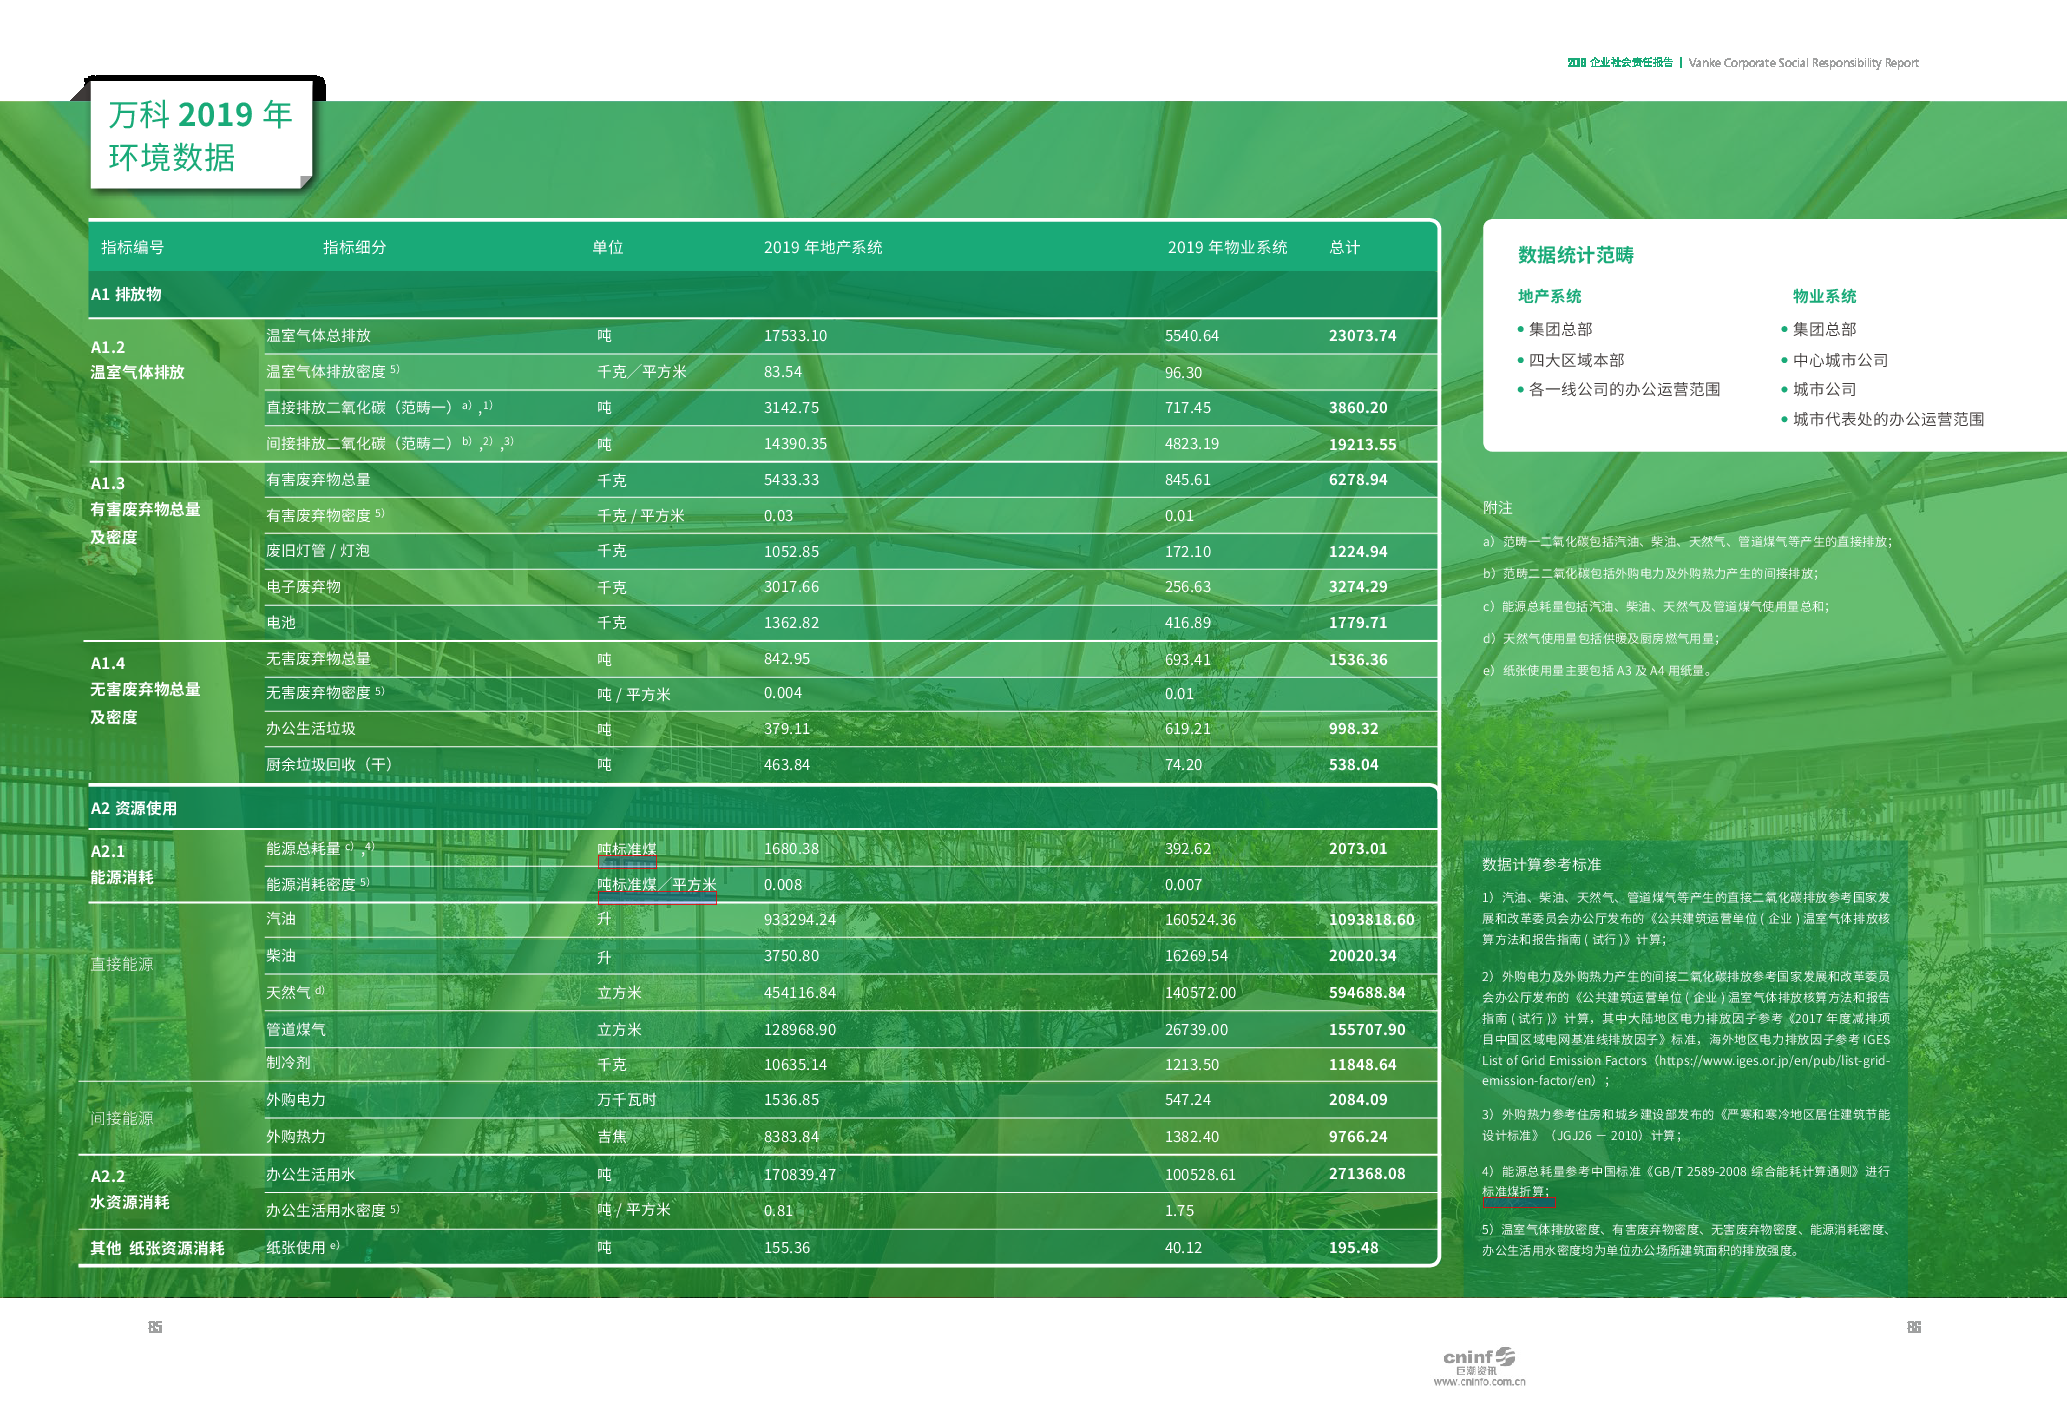

In [39]:
# 搜某公司煤的使用量
company_id = "000002"

idx = index.open_dir(company_id)
to_search = input("输入你要搜索的关键词，用空格隔开，比如：标准 煤 吨： ")
to_search_list = to_search.split(" ")
query_list = [Term("content",i) for i in to_search_list]
myquery = Or(query_list)

with idx.searcher() as searcher:  
    
    results = searcher.search(myquery)
    if len(results) == 0:
        print("没有找到你想检索的内容No hits found")
    else:
        
        page_number = int(results[0]["page"])
        results.fragmenter = highlight.ContextFragmenter(maxchars=200, surround=40, charlimit=32768)
        results.formatter = highlight.UppercaseFormatter()
        outputs = [hit.highlights("content") for hit in results]
        
        
        for i in range(len(outputs)):
            page_num = results[i]["page"]
            output = outputs[i]
            print("="*15 +"Page "+ page_num+"="*15)
            print(output)
        page_number=input("【必须回答】你想打开pdf的第几页查看原图？(ex. 44) 如果不需要请输入n:  ")
        if page_number != "n":
            
            fp = "pdfs/"+company_id+".pdf"
            my_pdf = pdfplumber.open(fp)
            pages = my_pdf.pages 
            page = pages[int(page_number)]
            a = "|".join(to_search_list)

            im = page.to_image(resolution=125)
            dic = page.extract_words()
            pattern = re.compile(r""+a)
            print(pattern)

            result = [i for i in dic if bool(pattern.search(i["text"]))]
            im.reset()
            #用方框 在图片中标注出 目标词
            im.draw_rects(result)
            display(im)